In [1]:
%pip install torch==2.1.0 torchvision==0.16.0 scikit-learn umap-learn giotto-tda matplotlib pandas tqdm numpy



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Found existing installation: numpy 2.0.0
Not uninstalling numpy at /Users/nhaile/Library/Python/3.9/lib/python/site-packages, outside environment /Users/nhaile/Documents/Neural Network Research/venv
Can't uninstall 'numpy'. No files were found to uninstall.


In [3]:
import warnings
warnings.filterwarnings("ignore")


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, models
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, NumberOfPoints
import umap

In [33]:
import seaborn as sns


In [39]:
from sklearn.decomposition import PCA


In [7]:
dataset = "moons"   # Change to "donuts" if you want both MLPs on circles dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [9]:
class SmallMLP(nn.Module):
    def __init__(self, in_dim=2, hidden=3, out_dim=2):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(in_dim, hidden),
            nn.Linear(hidden, hidden),
            nn.Linear(hidden, out_dim)
        ])

    def forward(self, x):
        activations = []
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
            activations.append(x.detach())
        x = self.layers[-1](x)
        activations.append(x.detach())
        return x, activations

class DeepMLP(nn.Module):
    def __init__(self, in_dim=2, hidden=6, out_dim=2, depth=6):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(in_dim, hidden)])
        for _ in range(depth - 2):
            self.layers.append(nn.Linear(hidden, hidden))
        self.layers.append(nn.Linear(hidden, out_dim))

    def forward(self, x):
        activations = []
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
            activations.append(x.detach())
        x = self.layers[-1](x)
        activations.append(x.detach())
        return x, activations

def train_model(model, X, y, epochs=500, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        out, _ = model(X)
        loss = F.cross_entropy(out, y)
        loss.backward()
        optimizer.step()
    return model

class MNISTMLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.ModuleList([
            torch.nn.Linear(28*28, 256),
            torch.nn.Linear(256, 128),
            torch.nn.Linear(128, 64),
            torch.nn.Linear(64, 10)
        ])
    def forward(self, x):
        activations = []
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
            activations.append(x.detach())
        x = self.layers[-1](x)
        activations.append(x.detach())
        return x, activations

def train_mnist(model, X, y, epochs=3, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        out, _ = model(X)
        loss = F.cross_entropy(out, y)
        loss.backward()
        optimizer.step()
    return model

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

def plot_decision_boundary(model, X, y, title):
    """Visualize model decision boundary and class regions."""
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_t = torch.tensor(grid, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        logits, _ = model(grid_t)
        preds = logits.argmax(dim=1).cpu().numpy().reshape(xx.shape)
    
    cmap_light = ListedColormap(["#FFAAAA", "#AAAAFF"])
    cmap_bold = ListedColormap(["#FF0000", "#0000FF"])
    
    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, preds, cmap=cmap_light, alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor="k", s=25)
    plt.title(title)
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    plt.show()


In [11]:
if dataset == "moons":
    from sklearn.datasets import make_moons
    X, y = make_moons(n_samples=800, noise=0.1, random_state=42)
elif dataset == "donuts":
    from sklearn.datasets import make_circles
    X, y = make_circles(n_samples=800, noise=0.05, factor=0.5, random_state=42)
else:
    raise ValueError("dataset must be 'moons' or 'donuts'")

X_toy = torch.tensor(StandardScaler().fit_transform(X), dtype=torch.float32).to(device)
y_toy = torch.tensor(y, dtype=torch.long).to(device)

# MNIST data for MNISTMLP
transform_mnist = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform_mnist)
X_mnist = mnist_train.data[:2000].float().view(-1, 28*28) / 255.0
y_mnist = mnist_train.targets[:2000]

# CIFAR for AlexNet
transform_cifar = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
cifar = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_cifar)
loader_cifar = DataLoader(cifar, batch_size=32, shuffle=False)

In [12]:
def compute_log_volume(activation):
    """Compute log-volume via covariance determinant."""
    act_np = activation.detach().cpu().numpy()
    cov = np.cov(act_np.T)
    det = np.linalg.det(cov + 1e-10 * np.eye(cov.shape[0]))
    return np.log(np.abs(det) + 1e-10)

def get_weight_stats(model):
    """Get simple summary stats of model weights."""
    weights = torch.cat([p.flatten() for p in model.parameters()])
    return {
        "mean": weights.mean().item(),
        "std": weights.std().item(),
        "norm": torch.norm(weights).item()
    }

def get_betti_numbers(activation):
    """Compute Betti numbers using Giotto-TDA."""
    X = activation.detach().cpu().numpy()
    vr = VietorisRipsPersistence(homology_dimensions=[0,1,2])
    diagrams = vr.fit_transform([X])
    betti = []
    for dim in range(3):
        betti.append(sum(diagrams[0][:,1] - diagrams[0][:,0] > 0))
    return betti

In [15]:
toy_loader = DataLoader(TensorDataset(X_toy, y_toy), batch_size=32, shuffle=False)
mnist_loader = DataLoader(TensorDataset(X_mnist, y_mnist), batch_size=32, shuffle=False)


Analyzing SmallMLP...

Analyzing DeepMLP...

Analyzing MNISTMLP...


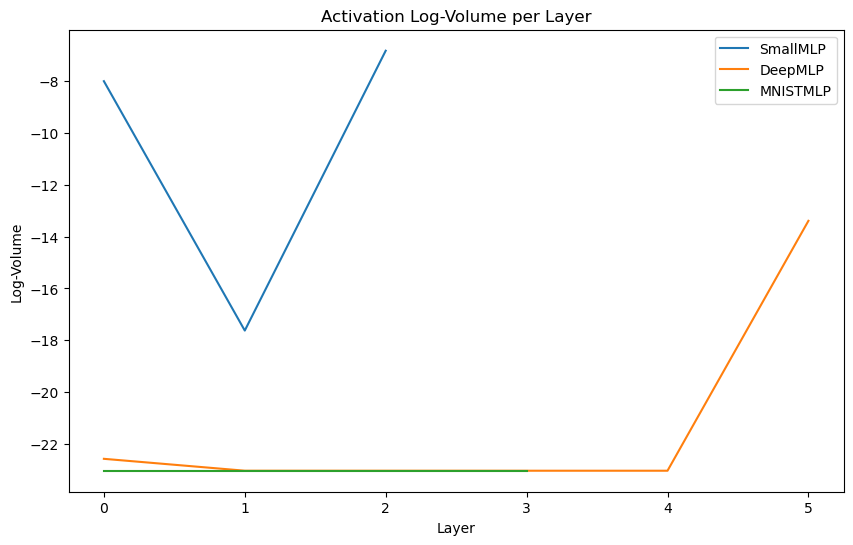

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = []
for name, model, data_loader in [
    ("SmallMLP", SmallMLP(), toy_loader),  # Use toy dataset
    ("DeepMLP", DeepMLP(), toy_loader),   # Use toy dataset
    ("MNISTMLP", MNISTMLP(), mnist_loader)
#    ,("AlexNet", models.alexnet(pretrained=True).features, loader_cifar)
]:
    model.to(device)
    model.eval()
    print(f"\nAnalyzing {name}...")


    if name in ["SmallMLP", "DeepMLP", "MNISTMLP"]:
        X_batch, y_batch = next(iter(data_loader))
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        if name == "MNISTMLP":
            X_batch = X_batch.view(X_batch.size(0), -1)
            model = train_mnist(model, X_batch, y_batch)
        else:
            model = train_model(model, X_batch, y_batch)

    weight_stats = get_weight_stats(model)
    layer_volumes = []
    layer_bettis = []

    # Single pass for activation collection
    for X_batch, y_batch in data_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        if name == "MNISTMLP":
            X_batch = X_batch.view(X_batch.size(0), -1)
        if name == "AlexNet":
            continue
            activations = []
            def hook_fn(_, __, output): activations.append(output.detach().view(output.size(0), -1))
            hooks = [layer.register_forward_hook(hook_fn) for layer in model]
            _ = model(X_batch)
            for h in hooks: h.remove()
        else:
            _, activations = model(X_batch)


        for act in activations:
            vol = compute_log_volume(act)
            betti = get_betti_numbers(act)
            layer_volumes.append(vol)
            layer_bettis.append(betti)
        break  

    results.append({
        "model": name,
        "layer_volumes": layer_volumes,
        "layer_bettis": layer_bettis,
        **weight_stats
    })


plt.figure(figsize=(10,6))
for res in results:
    plt.plot(range(len(res["layer_volumes"])), res["layer_volumes"], label=res["model"])
plt.xlabel("Layer")
plt.ylabel("Log-Volume")
plt.title("Activation Log-Volume per Layer")
plt.legend()
plt.show()

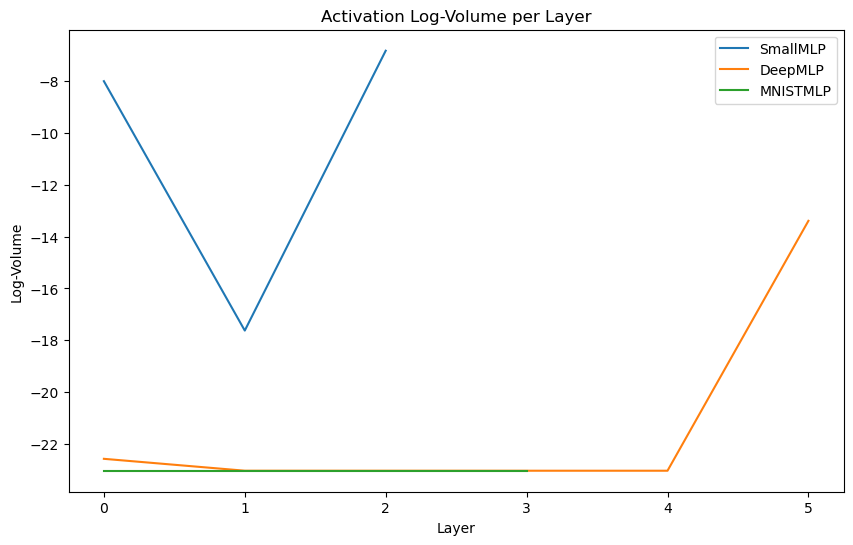

In [21]:

plt.figure(figsize=(10,6))
for res in results:
    plt.plot(range(len(res["layer_volumes"])), res["layer_volumes"], label=res["model"])
plt.xlabel("Layer")
plt.ylabel("Log-Volume")
plt.title("Activation Log-Volume per Layer")
plt.legend()
plt.show()

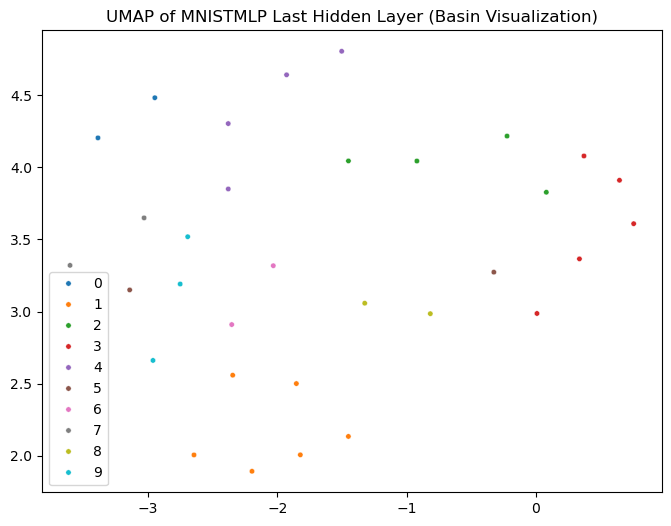

In [35]:
model = MNISTMLP().to(device)
X_batch, y_batch = next(iter(mnist_loader))
X_batch = X_batch.to(device).view(X_batch.size(0), -1)
y_batch = y_batch.to(device)
model = train_mnist(model, X_batch, y_batch)

_, activations = model(X_batch)
act_last = activations[-2].detach().cpu().numpy()   
labels = y_batch.detach().cpu().numpy()


reducer = umap.UMAP(n_neighbors=20, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(act_last)

plt.figure(figsize=(8,6))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=labels, palette="tab10", s=15)
plt.title("UMAP of MNISTMLP Last Hidden Layer (Basin Visualization)")
plt.show()

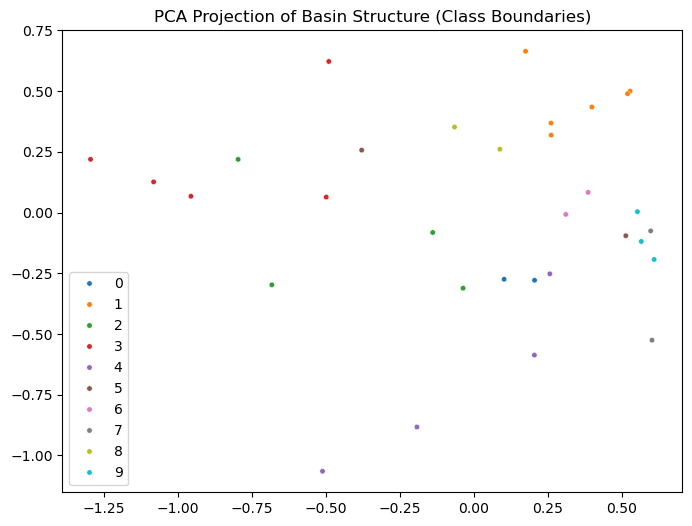

In [41]:
pca = PCA(n_components=2)
pca_emb = pca.fit_transform(act_last)
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_emb[:,0], y=pca_emb[:,1], hue=labels, palette="tab10", s=15)
plt.title("PCA Projection of Basin Structure (Class Boundaries)")
plt.show()

In [43]:
results

[{'model': 'SmallMLP',
  'layer_volumes': [-8.013028244962529,
   -17.62431054460119,
   -6.839273306711439],
  'layer_bettis': [[34, 34, 34], [31, 31, 31], [31, 31, 31]],
  'mean': -0.13001181185245514,
  'std': 0.9702225923538208,
  'norm': 5.181455612182617},
 {'model': 'DeepMLP',
  'layer_volumes': [-22.567069652476707,
   -23.02536774792933,
   -23.02585092606892,
   -23.025850929940457,
   -23.025850929940457,
   -13.394636821390042],
  'layer_bettis': [[33, 33, 33],
   [32, 32, 32],
   [33, 33, 33],
   [31, 31, 31],
   [31, 31, 31],
   [31, 31, 31]],
  'mean': -0.05518973246216774,
  'std': 0.43554696440696716,
  'norm': 6.193521499633789},
 {'model': 'MNISTMLP',
  'layer_volumes': [-23.025850929940457,
   -23.025850929940457,
   -23.025850929940457,
   -23.025850929940432],
  'layer_bettis': [[41, 41, 41], [43, 43, 43], [40, 40, 40], [40, 40, 40]],
  'mean': -3.1043539365782635e-06,
  'std': 0.025276727974414825,
  'norm': 12.45401668548584}]